In [1]:
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as T
from collections import defaultdict, deque
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import ast
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
import torchvision.transforms as transforms
import cv2
import os,sys,matplotlib,re
from PIL import Image
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as immg
from torchvision.io import read_image
import matplotlib
from torchvision.utils import draw_bounding_boxes
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("new_train.csv")
df

,image_id,width,height,bbox,source,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,train/b6ab77fd7.jpg,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,train/b6ab77fd7.jpg,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,train/b6ab77fd7.jpg,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,train/b6ab77fd7.jpg,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,train/b6ab77fd7.jpg,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...,...
147788,train/5e0747034.jpg,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,64.0,619.0,84.0,95.0
147789,train/5e0747034.jpg,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,292.0,549.0,107.0,82.0
147790,train/5e0747034.jpg,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,134.0,228.0,141.0,71.0
147791,train/5e0747034.jpg,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,430.0,13.0,184.0,79.0


In [3]:
class WheatDataset(object):
    def __init__(self, df, img_dir, transforms = None):
        super().__init__()
        self.a = 0
        self.df = df
        self.img_dir = img_dir
        self.image_ids = self.df["image_id"].unique()
        self.transforms = transforms
    def __len__(self):
        return len(self.image_ids)
    def __getitem__(self,idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]
#         print(self.img_dir,image_id)
        image = cv2.imread(image_id,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].to_numpy()
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros((records.shape[0],), dtype=torch.int64)
    
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        return image.clone().detach(), target, image_id

In [4]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [5]:
WD = WheatDataset(df, "train/", get_train_transform())

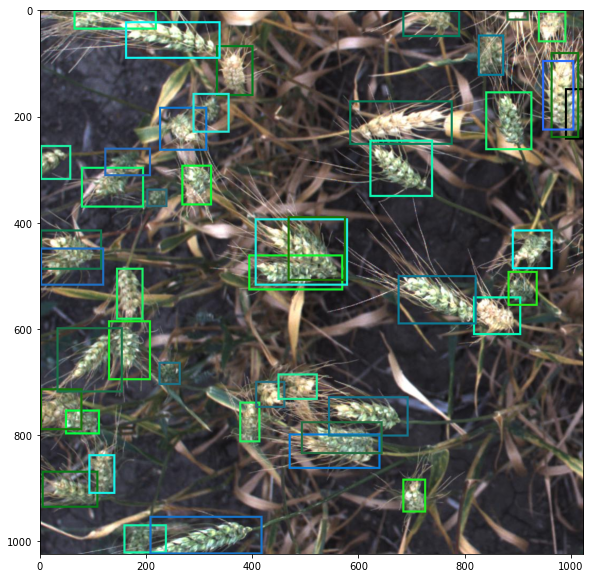

In [6]:
fig = plt.figure(figsize=(14, 10))
sample = WD[1]
# print(sample[1])
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], width=4
).permute(1, 2, 0))

In [7]:
image_ids = df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [8]:
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]

In [9]:
valid_df.shape, train_df.shape

((25006, 9), (122787, 9))

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, "train/", get_train_transform())
valid_dataset = WheatDataset(valid_df, "train/", get_valid_transform())

indices = torch.randperm(len(train_dataset)).tolist()
train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [11]:
num_classes = 2  

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [12]:
model.to("cuda:0")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [13]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to("cuda:0") for image in images)
targets = [{k: v.to("cuda:0") for k, v in t.items()} for t in targets]

In [14]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets,_ in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) 
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") 
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [15]:
num_epochs=3
device = "cuda:0"
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_data_loader, device, epoch)

  0%|          | 0/1354 [00:00<?, ?it/s]

Epoch 0, lr: 0.005000, loss: 0.910430, loss_classifier: 0.252001, loss_box: 0.491964, loss_rpn_box: 0.087544, loss_object: 0.078921


  0%|          | 0/1354 [00:00<?, ?it/s]

Epoch 1, lr: 0.005000, loss: 0.813571, loss_classifier: 0.225250, loss_box: 0.457292, loss_rpn_box: 0.075570, loss_object: 0.055458


  0%|          | 0/1354 [00:00<?, ?it/s]

Epoch 2, lr: 0.005000, loss: 0.783550, loss_classifier: 0.216243, loss_box: 0.444701, loss_rpn_box: 0.072120, loss_object: 0.050487


In [16]:
images, targets, image_ids = next(iter(valid_data_loader))

In [17]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [18]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [19]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [21]:
def apply_nms(orig_prediction, iou_thresh=0.2):
    

    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [51]:
img,target,_ = valid_dataset[43]
# print(img)
model.eval()
with torch.no_grad():
    prediction = model([img.to('cuda')])[0]

nms_prediction = apply_nms(prediction, iou_thresh=0.7)
print(nms_prediction)

{'boxes': tensor([[2.1519e+02, 7.0960e+02, 3.7568e+02, 8.4268e+02],
        [1.8355e+02, 3.4020e+02, 2.7673e+02, 4.4017e+02],
        [4.0943e+01, 1.4900e+02, 1.3787e+02, 2.4311e+02],
        [4.1839e+02, 3.0822e+02, 5.5884e+02, 4.6886e+02],
        [4.1217e+02, 5.3336e+02, 5.1351e+02, 6.4745e+02],
        [6.3068e+02, 9.3875e+02, 7.4502e+02, 1.0158e+03],
        [4.2703e+02, 9.0621e+02, 5.1279e+02, 1.0015e+03],
        [9.2720e+02, 1.6942e+02, 1.0130e+03, 3.6363e+02],
        [7.2363e+02, 6.9924e+01, 8.4992e+02, 1.5295e+02],
        [2.6453e+02, 7.0586e-01, 3.3826e+02, 8.1884e+01],
        [7.9821e+02, 1.8762e+02, 8.7614e+02, 2.5884e+02],
        [9.3793e+02, 8.5748e+00, 1.0218e+03, 9.2249e+01],
        [9.1165e+02, 4.2342e+02, 1.0237e+03, 6.0843e+02],
        [6.3564e+02, 5.1749e+02, 7.2893e+02, 5.8848e+02],
        [6.2287e+02, 5.9426e+02, 7.0679e+02, 6.7099e+02],
        [6.2034e+01, 8.6934e+02, 2.4125e+02, 9.7369e+02],
        [7.2088e+02, 8.8394e+02, 7.9949e+02, 9.5517e+02],
    

In [61]:
# boxes = nms_prediction['boxes'].data.cpu().numpy()
# print(boxes[0])
# boxes = boxes.astype(np.int32)
# boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
# boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
# boxes

[215.19156 709.5994  375.67856 842.68427]


array([[ 215,  709,  160,  133],
       [ 183,  340,   93,  100],
       [  40,  148,   97,   95],
       [ 418,  308,  140,  160],
       [ 412,  533,  101,  114],
       [ 630,  938,  115,   77],
       [ 427,  906,   85,   95],
       [ 927,  169,   85,  194],
       [ 723,   69,  126,   83],
       [ 264,    0,   74,   81],
       [ 798,  187,   78,   71],
       [ 937,    8,   84,   84],
       [ 911,  423,  112,  185],
       [ 635,  517,   93,   71],
       [ 622,  594,   84,   76],
       [  62,  869,  179,  104],
       [ 720,  883,   79,   72],
       [ 646,   10,  104,   65],
       [ 210,  529,   67,   75],
       [ 690,  323,   81,   80],
       [ 485,  455,   71,   69],
       [   2,  492,   69,   73],
       [ 826,  393,   87,   73],
       [ 179,    0,   68,   50],
       [ 854,  513,   62,   62],
       [ 978,  944,   46,   62],
       [ 236,  853,   66,   72],
       [ 910,  523,   71,   88],
       [ 338,    0,   90,   32],
       [   0,  566,   53,   74],
       [  

REAL BOXES


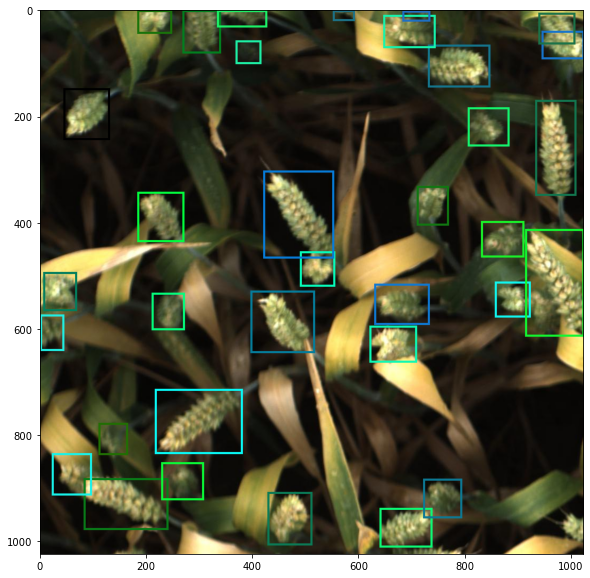

In [62]:
print("REAL BOXES")
fig = plt.figure(figsize=(14, 10))
sample = valid_dataset[43]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], width=4
).permute(1, 2, 0))

PREDICTED BOXES


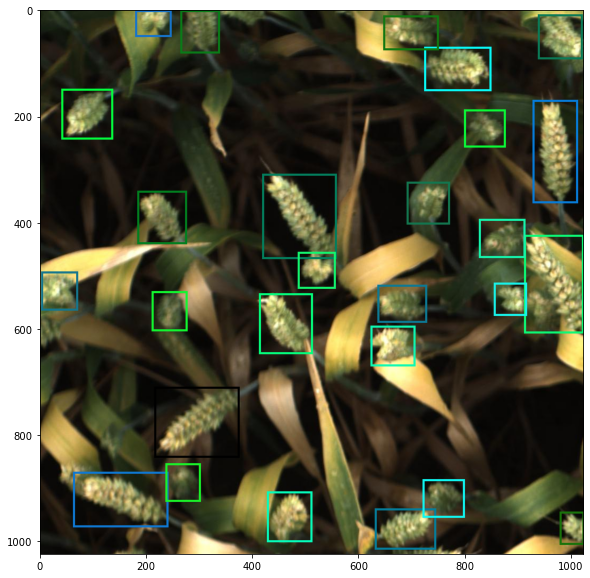

In [24]:
print("PREDICTED BOXES")
fig = plt.figure(figsize=(14, 10))
sample = valid_dataset[43]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(img_int,
    nms_prediction['boxes'][nms_prediction['scores'] > 0.8], width=4
).permute(1, 2, 0))

In [26]:
test_df = pd.read_csv("sample_submission.csv")
test_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [27]:
test_df.shape

(10, 2)

In [28]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [29]:
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [34]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, "test", get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [35]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [63]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)
#     print(outputs)
    for i, image in enumerate(images):
        
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)


In [39]:
results[0:2]

[{'image_id': 'aac893a91',
  'PredictionString': '0.9855 620 918 73 105 0.9795 74 4 97 157 0.9778 362 531 89 83 0.9777 695 393 119 182 0.9720 463 859 74 86 0.9703 597 779 80 118 0.9684 30 454 100 155 0.9659 561 532 116 189 0.9605 743 773 73 111 0.9587 310 0 65 66 0.9586 562 65 129 193 0.9497 56 852 127 77 0.9305 825 709 97 196 0.9173 239 843 93 77 0.9030 252 100 121 131 0.8985 92 621 118 70 0.8883 187 600 101 156 0.8090 320 861 71 92 0.7524 334 673 104 138 0.6121 456 691 103 95 0.5866 829 939 115 83 0.5401 361 264 89 140 0.5129 385 342 76 72 0.5103 337 665 73 90'},
 {'image_id': '51f1be19e',
  'PredictionString': '0.9455 503 472 203 108 0.9362 614 95 145 169 0.9293 818 91 107 70 0.9252 32 0 78 68 0.9180 284 474 127 117 0.9063 650 794 110 80 0.8931 821 762 91 84 0.8711 699 920 78 82 0.8648 1 376 54 98 0.8589 784 27 110 66 0.8330 861 651 153 85 0.8069 575 600 97 109 0.7861 71 692 132 220 0.7822 206 941 88 81 0.7414 868 290 105 176 0.7235 782 887 128 85 0.6767 676 591 89 83 0.6740 363 136

In [41]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df

,image_id,PredictionString
0,aac893a91,0.9855 620 918 73 105 0.9795 74 4 97 157 0.977...
1,51f1be19e,0.9455 503 472 203 108 0.9362 614 95 145 169 0...
2,f5a1f0358,0.9841 546 276 105 107 0.9824 549 407 74 87 0....
3,796707dd7,0.9771 902 333 100 89 0.9735 510 793 85 88 0.9...
4,51b3e36ab,0.9926 867 289 157 136 0.9925 549 35 244 134 0...
5,348a992bb,0.9923 742 228 128 82 0.9900 286 342 75 85 0.9...
6,cc3532ff6,0.9958 774 835 164 160 0.9917 378 4 79 93 0.99...
7,2fd875eaa,0.9965 460 503 81 132 0.9960 2 911 103 82 0.99...
8,cb8d261a3,0.9887 28 554 181 115 0.9812 755 715 81 83 0.9...
9,53f253011,0.9925 469 465 152 196 0.9889 935 203 88 131 0...


In [42]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


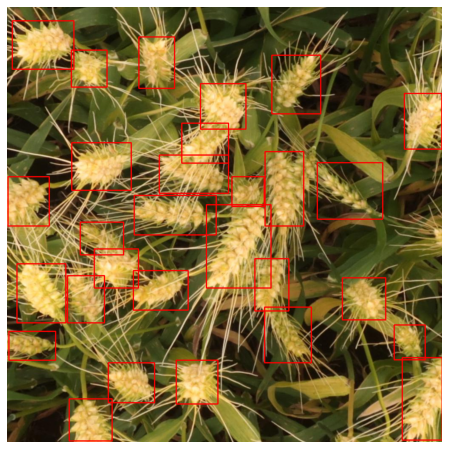

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [46]:
test_df.to_csv('my_submission.csv', index=False)